Metro Flow data from:

https://github.com/HCPLab-SYSU/PVCGN/blob/master/data/README.md

In [ ]:
import pickle
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
import os
from chinese_calendar import is_holiday, is_workday
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatter
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
#缺失数据

***
### 1. learn dataset

In [4]:
root_path = 'temp/otherData/shanghai/'
with open(root_path + 'test.pkl','rb') as infile:
    test_dataset = pickle.load(infile)
print(test_dataset['x'].shape) # [T, n, N, D]
print(test_dataset['y'].shape) # [T, m, N, D]

(1386, 4, 288, 2)
(1386, 4, 288, 2)


In [3]:
print(test_dataset['xtime'].shape)
print(test_dataset['ytime'].shape)

(1386, 4)
(1386, 4)


In [4]:
test_dataset['xtime'][0][0]

numpy.datetime64('2016-09-10T05:30:00.000000000')

In [5]:
with open(root_path + 'graph_sh_conn.pkl','rb') as infile:
    graph = pickle.load(infile)
graph

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.]])

#### 288 个站点，缺少站点名称与位置，对应不上，只能看全网总流量

决定对比工作日 // 非工作日，分小时 Demand总量 和 方差

***

### 2. Extract Data

In [5]:
with open(root_path + 'train.pkl','rb') as infile:
    train_dataset = pickle.load(infile)

with open(root_path + 'val.pkl','rb') as infile:
    val_dataset = pickle.load(infile)

with open(root_path + 'test.pkl','rb') as infile:
    test_dataset = pickle.load(infile)

time_bins = []
time_bins.extend(list(train_dataset['xtime'].reshape(-1)))
time_bins.extend(list(train_dataset['ytime'].reshape(-1)))
time_bins.extend(list(val_dataset['xtime'].reshape(-1)))
time_bins.extend(list(val_dataset['ytime'].reshape(-1)))
time_bins.extend(list(test_dataset['xtime'].reshape(-1)))
time_bins.extend(list(test_dataset['ytime'].reshape(-1)))
time_bins = sorted(list(set(time_bins)))
time_bins = np.array(time_bins, dtype='datetime64[s]')
print(len(time_bins))


6716


In [6]:
dict_ridership = {} # {timeStamp: (288, 2)}

datasetList = [train_dataset, val_dataset, test_dataset]

for dataset in datasetList:
    sampleID = 0
    slotID = 0
    for timeGroup in dataset['xtime']:
        for time in timeGroup:
            if time not in dict_ridership.keys():
                dict_ridership[time.astype('datetime64[s]')] = dataset['x'][sampleID, slotID]
            slotID += 1
        sampleID +=1
        slotID = 0

    sampleID = 0
    slotID = 0
    for timeGroup in dataset['ytime']:
        for time in timeGroup:
            if time not in dict_ridership.keys():
                dict_ridership[time.astype('datetime64[s]')] = dataset['y'][sampleID, slotID]
            slotID += 1
        sampleID +=1
        slotID = 0
    


***
### 3. Compare Dataset

In [7]:
workdayHour16 = np.zeros((17, 288)) # 6:00-23:00 hourly avg
holidayHour16 = np.zeros((17, 288)) 
workdayCount16 = 0
holidayCount16 = 0

# First Day
date_obj_cache = time_bins[0].astype(datetime)
workday_tag = is_workday(date_obj_cache)
if workday_tag:
    workdayCount16 += 1
else:
    holidayCount16 += 1


for timeStamp in tqdm(time_bins):
    datetime_obj = timeStamp.astype(datetime)
    workday_tag = is_workday(datetime_obj)
    if datetime_obj.date() != date_obj_cache.date():
        if workday_tag:
            workdayCount16 += 1
        else:
            holidayCount16 += 1
        date_obj_cache = datetime_obj

    if datetime_obj.hour>=6 and datetime_obj.hour<=22:
        if workday_tag:
            workdayHour16[datetime_obj.hour - 6] += dict_ridership[timeStamp][:,0] + dict_ridership[timeStamp][:,1]
        else:
            holidayHour16[datetime_obj.hour - 6] += dict_ridership[timeStamp][:,0] + dict_ridership[timeStamp][:,1]

workdayHour16 = workdayHour16/workdayCount16
holidayHour16 = holidayHour16/holidayCount16

100%|██████████| 6716/6716 [00:00<00:00, 24451.79it/s]


In [8]:
root_path = '/data6/peiyan/SH-METR/results/' 
raw_data = pd.read_csv(os.path.join(root_path, 'metroData_Demandflow_10.csv'))
stationInfo = pd.read_csv('../../Metro/station_transInfo_cleaned.csv')
dict_staionName = dict(zip(stationInfo['stationID'], stationInfo['name']))
dict_stationLoc = dict(zip(stationInfo['stationID'], zip(stationInfo['lon'],stationInfo['lat'])))
stationID_List = list(stationInfo['stationID'])
raw_data

,date,timeslot,startTime,endTime,station,inFlow,outFlow,CinFlow,HO_inFlow,WO_inFlow,CoutFlow,HO_outFlow,WO_outFlow
0,20170501,0,60000,61000,112,29,32,9,15,0,11,13,1
1,20170501,0,60000,61000,113,142,102,40,51,4,30,41,1
2,20170501,0,60000,61000,114,66,35,17,19,7,12,10,2
3,20170501,0,60000,61000,119,23,14,6,9,0,1,3,2
4,20170501,0,60000,61000,124,17,21,2,4,2,0,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3788887,20170831,12545,225000,230000,2053,6,26,2,0,1,8,6,4
3788888,20170831,12545,225000,230000,2054,18,110,5,2,6,19,39,12
3788889,20170831,12545,225000,230000,2055,5,80,0,1,2,19,23,6
3788890,20170831,12545,225000,230000,2056,33,99,8,4,1,20,31,6


In [9]:
workdayHour17 = np.zeros((17, 302)) 
holidayHour17 = np.zeros((17, 302)) 
workdayCount17 = 0
holidayCount17 = 0

end_hour = 23
start_hour =6
abnormal_date = [20170504, 20170508, 20170509, 20170616, 20170627, 20170628]
date_cache = raw_data.values[0][0]

# First Day
workday_tag = is_workday(datetime.strptime(str(date_cache),"%Y%m%d"))
if workday_tag:
    workdayCount17 += 1
else:
    holidayCount17 += 1


for line in tqdm(raw_data.values):
    if line [0] in abnormal_date:
        continue
    
    datetime_obj = datetime.strptime(str(line[0]),"%Y%m%d")
    workday_tag = is_workday(datetime_obj)

    if  line[0] != date_cache:
        if workday_tag:
            workdayCount17 += 1
        else:
            holidayCount17 += 1
        date_cache = line[0]
    
    hour = line[2]//10000
    stationID = line[4]
 
    if hour>=6 and hour<=22:
        if workday_tag:
            workdayHour17[hour - 6, stationID_List.index(stationID)] += line[5] + line [6]
        else:
            holidayHour17[hour - 6, stationID_List.index(stationID)] += line[5] + line [6]

workdayHour17 = workdayHour17/workdayCount17
holidayHour17 = holidayHour17/holidayCount17

100%|██████████| 3788892/3788892 [02:37<00:00, 24011.67it/s] 


***
### 4. visualize

In [16]:
def plot_data(workdayHour16,workdayHour17,holidayHour16,holidayHour17):
    fig, axs = plt.subplots(1,2, figsize=(12,5),dpi=300)
    
    # sum
    hourAvg16= np.concatenate((np.sum(workdayHour16, axis=1),np.sum(holidayHour16, axis=1)))
    hourAvg17= np.concatenate((np.sum(workdayHour17, axis=1),np.sum(holidayHour17, axis=1)))
    #correlation = np.corrcoef(hourAvg16, hourAvg17)[0, 1]
    correlation, p = pearsonr(hourAvg16, hourAvg17)
    print(correlation, p)
    axs[0].scatter(hourAvg16, hourAvg17, s=20, facecolor='green', edgecolors='black', linewidths=0.5, zorder=1)
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_title("Comparison of total flow \n aggregated by hour", fontsize=15)
    axs[0].set_xlabel('Comparative Dataset', fontsize=15)
    axs[0].set_ylabel('Our Dataset', fontsize=15)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].text(0.7, 0.25, 'corr='+str(round(correlation,3))+'\np<0.01', transform=axs[0].transAxes,fontsize=15,linespacing=2, multialignment='left',
    bbox=dict(facecolor='white', edgecolor='black'))
    axs[0].tick_params(labelsize=12)

    model = LinearRegression()
    log_x = np.log(hourAvg16.reshape(-1,1))
    log_y = np.log(hourAvg17.reshape(-1,1))
    model.fit(log_x,log_y ) # 用对数空间的坐标训练参数
    y_pred_log = model.predict(log_x)
    axs[0].plot(hourAvg16, np.exp(y_pred_log), 'r--',zorder=0)  # 将对数预测值转换回原始空间



    # variance
    hourVar16 = np.concatenate((np.var(workdayHour16, axis=1),np.var(holidayHour16, axis=1)))
    hourVar17 = np.concatenate((np.var(workdayHour17, axis=1),np.var(holidayHour17, axis=1)))
    #correlation = np.corrcoef(hourVar16, hourVar17)[0, 1]
    correlation, p = pearsonr(hourVar16, hourVar17)
    print(correlation, p)
    axs[1].scatter(hourVar16, hourVar17, s=20, facecolor='green', edgecolors='black', linewidths=0.5, zorder=1)
    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_title('Comparison of flow variance across metro stations \n aggregated by hour', fontsize=15)
    axs[1].set_xlabel('Comparative Dataset', fontsize=15)
    axs[1].set_ylabel('Our Dataset', fontsize=15)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].text(0.7, 0.25, 'corr='+str(round(correlation,3))+'\np<0.01', transform=axs[1].transAxes,fontsize=15,linespacing=2, multialignment='left',
    bbox=dict(facecolor='white', edgecolor='black'))
    axs[1].tick_params(labelsize=12)

    model = LinearRegression()
    log_x = np.log(hourVar16.reshape(-1,1))
    log_y = np.log(hourVar17.reshape(-1,1))
    model.fit(log_x,log_y )
    y_pred_log = model.predict(log_x)
    axs[1].plot(hourVar16, np.exp(y_pred_log), 'r--',zorder=0)  # 将对数预测值转换回原始空间

    plt.savefig('../results/flow_comparison.pdf',dpi=300)

0.9956449151517819 1.489479545470644e-34
0.9913730355023139 8.122368994598164e-30


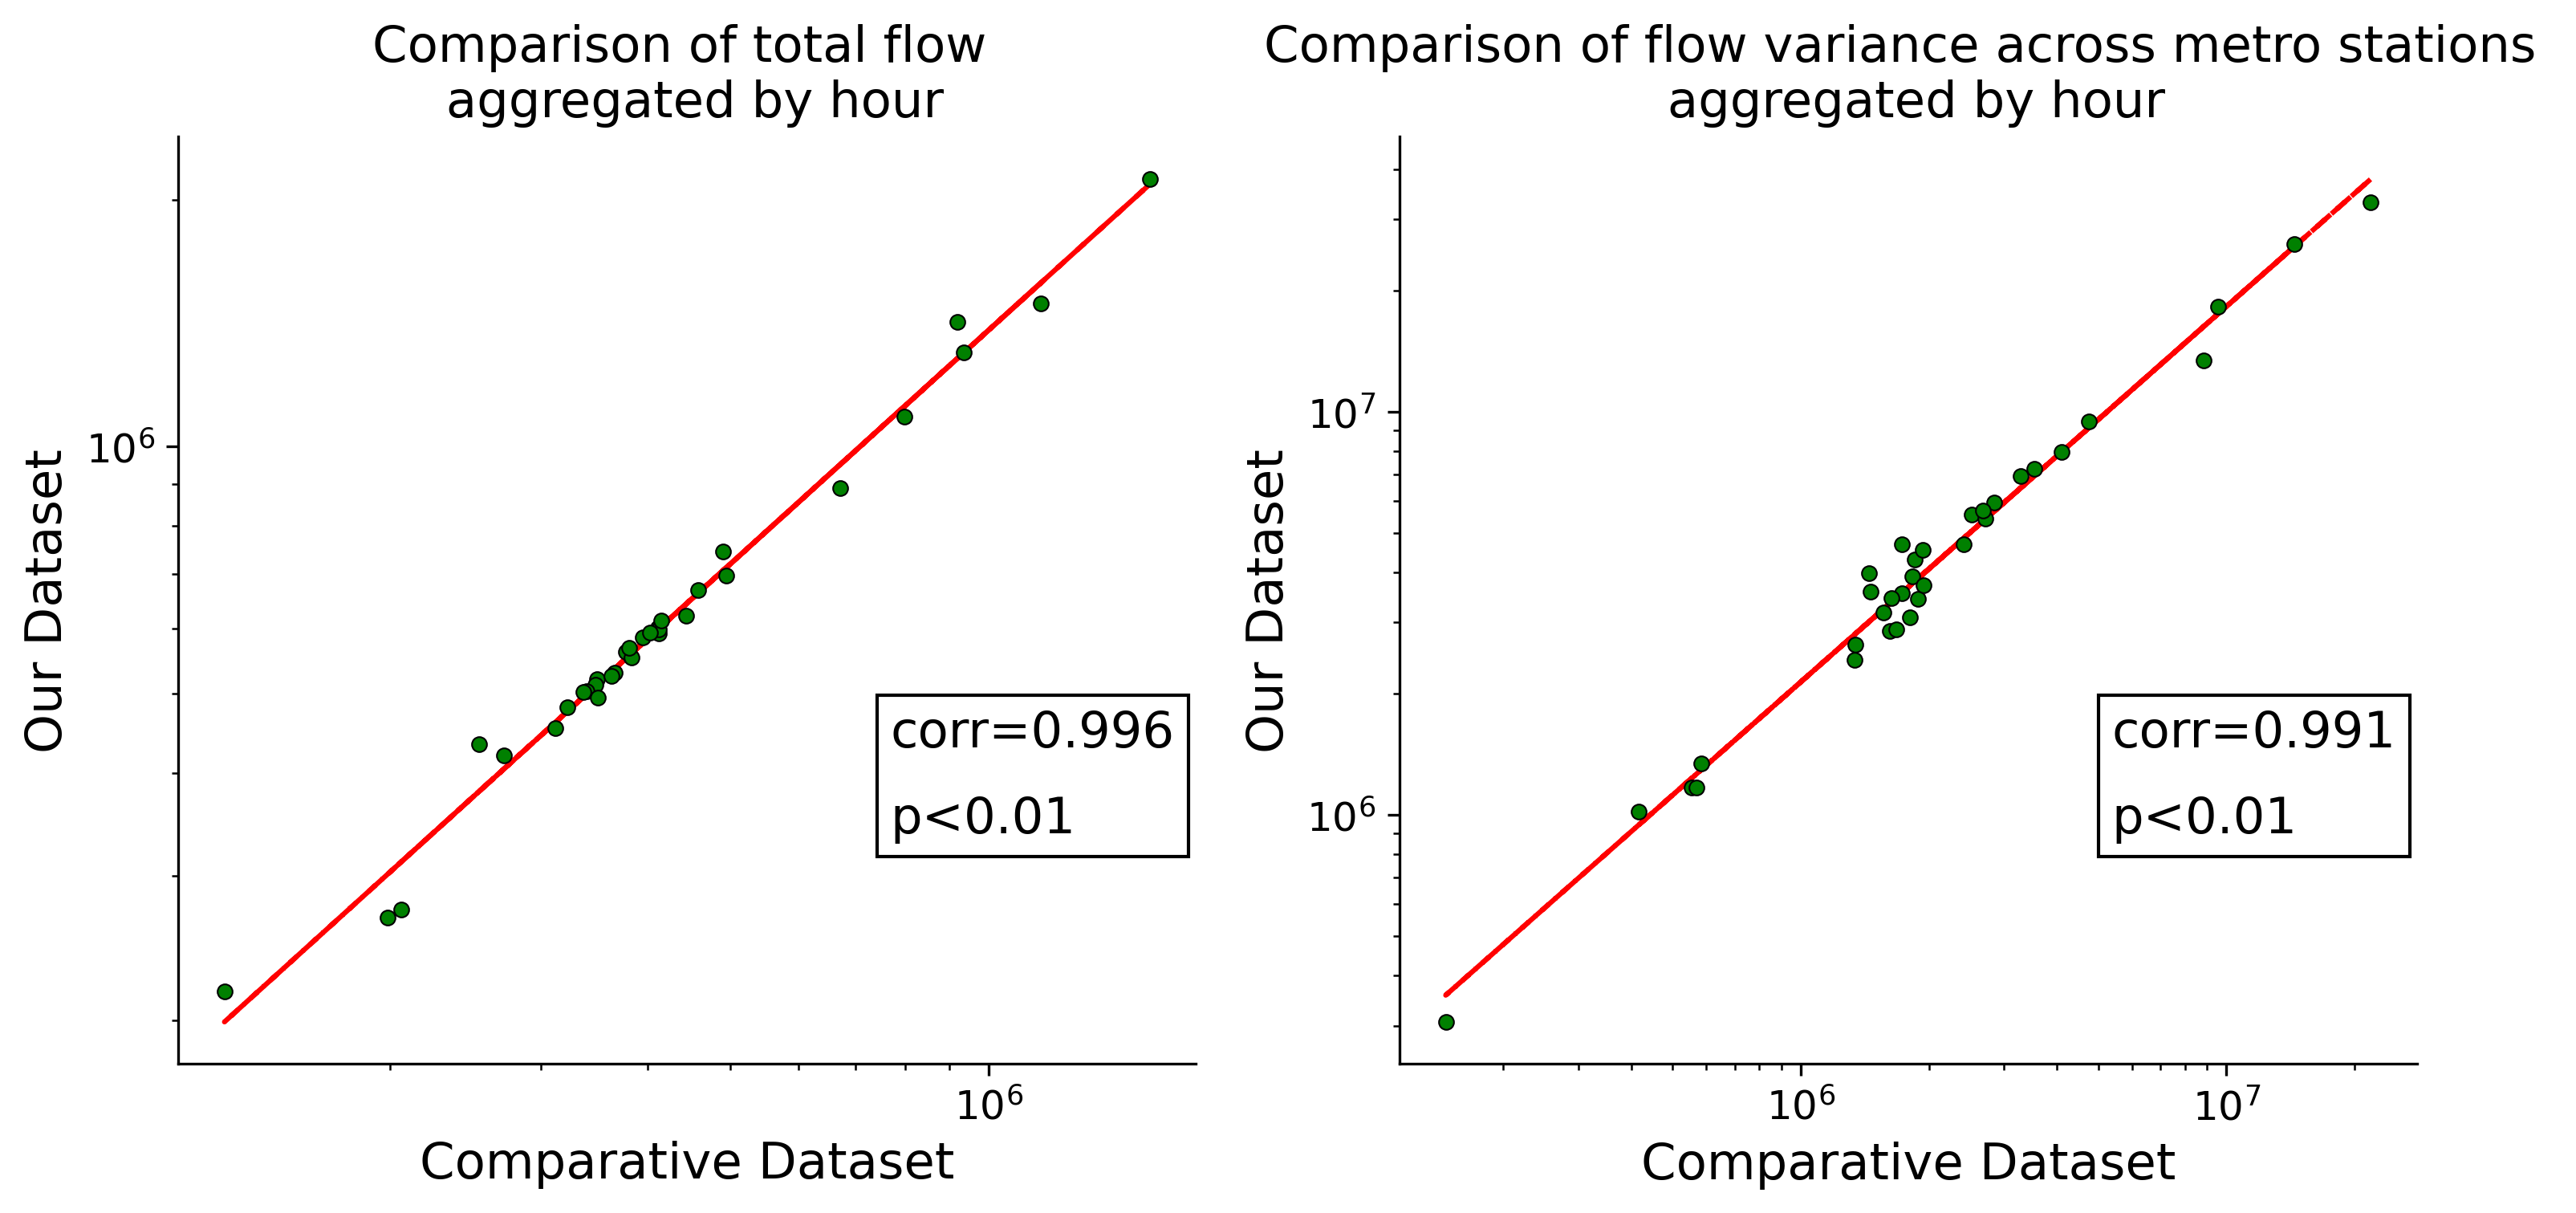

In [17]:
plot_data(workdayHour16,workdayHour17,holidayHour16,holidayHour17)

In [13]:
hourAvg16= np.concatenate((np.sum(workdayHour16, axis=1),np.sum(holidayHour16, axis=1)))
hourAvg17= np.concatenate((np.sum(workdayHour17, axis=1),np.sum(holidayHour17, axis=1)))
print(np.mean(hourAvg16))
print(np.mean(hourAvg17))

471234.2088989442
676674.1802832246


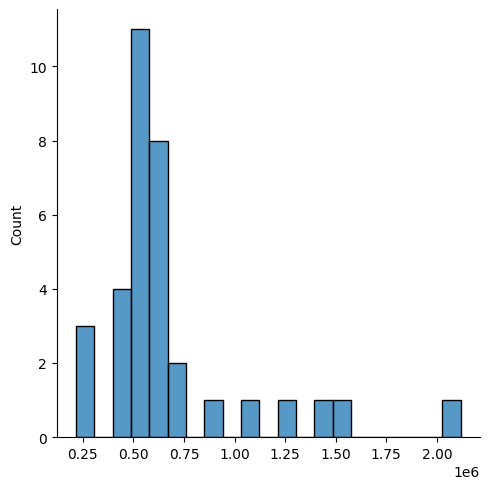

In [14]:
import seaborn as sns
sns.displot(hourAvg17)

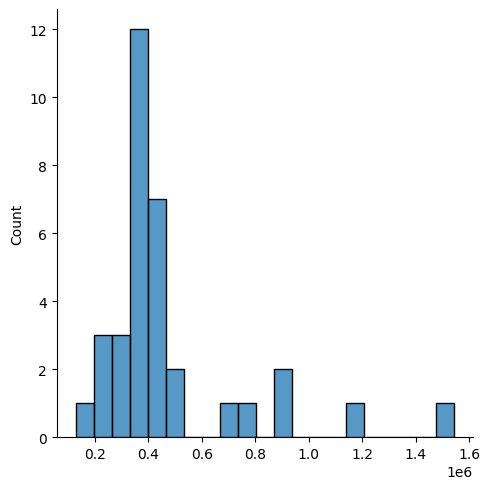

In [15]:
sns.displot(hourAvg16)